# Lamin Compute with Modal Backend

We show how to run compute jobs with Modal backend to run any script in the cloud without having to manage compute resources.

There are three major components to run compute jobs seemlessly in the cloud.

1. Access to your Artifacts and Data - (Lamin) 
2. Seemless access to a compute backend to run any workload - (Modal)
3. Tracking your workload inputs and outputs - (Lamin)

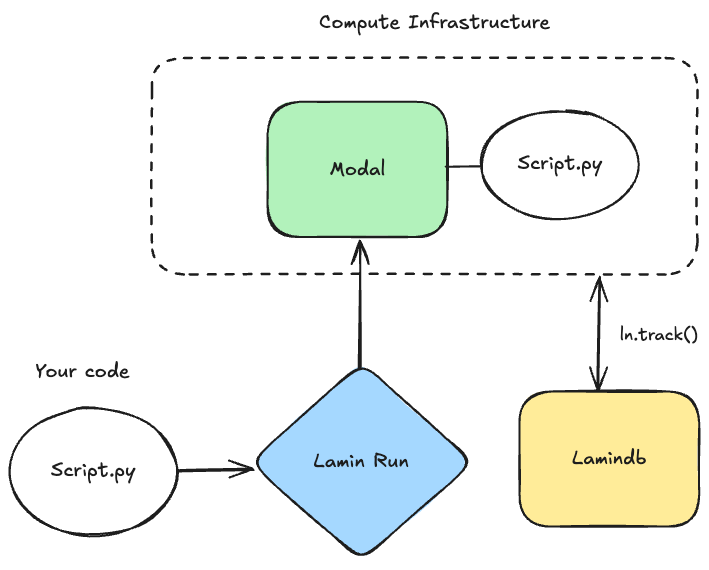

In [ ]:
# !pip install modal 'lamindb[jupyter]'
!modal setup

## Define your script

With `lamin run` you can define any python script and run it in the cloud with dedicated compute resources

We will save the following code locally as a script in `./helloworld.py` 

In [ ]:
import os
import lamindb as ln

API_KEY = os.environ['LAMIN_API_KEY']
PROJECT_NAME = "modal_project"

# LAMIN SETUP
ln.setup.login(api_key=API_KEY)
ln.connect('laminlabs/lamindata')
my_project = ln.Project(name=PROJECT_NAME).save()
ln.track(project=PROJECT_NAME)

# Your code 
def say_hello():
    print('Hello, World! lamin, user key has been passed successfully')

if __name__ == '__main__':
    say_hello()

## Track your code
ln.finish()

we save the above script as `./helloworld.py`

Execute the script in the cloud by running the following command from lamin CLI:
```
lamin run ./helloworld.py --project modal_project
```

In [ ]:
# !lamin run ./helloworld.py --project modal_project

#### Flow explained

1. Lamin wraps your script and sends it as modal job where it spins a docker container that executes your code.
2. Your code is then tracked through lamindb as a `transform` where inputs and outputs are mapped accordingly

## An example interacting with lamin Artifact with remote jobs

In [ ]:
import os
import lamindb as ln

API_KEY = os.environ['LAMIN_API_KEY']
PROJECT_NAME = 'modal_sc'

# LAMIN SETUP
ln.setup.login(api_key=API_KEY)
ln.connect('laminlabs/lamindata')
ln.track()  # track your run of a notebook or script 

def main():
    # Access inputs -------------------------------------------
    artifact = ln.Artifact.using("laminlabs/cellxgene").get("7dVluLROpalzEh8m")  # query the artifact https://lamin.ai/laminlabs/cellxgene/artifact/7dVluLROpalzEh8m
    adata = artifact.load()[:, :100]  # load into memory or sync to cache: filepath = artifact.cache()
    
    # Your transformation -------------------------------------
    
    import scanpy as sc  # find marker genes with Scanpy
    
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.tl.rank_genes_groups(adata, groupby="cell_type")
    
    # Save outputs --------------------------------------------
    
    ln.Artifact.from_anndata(adata, key="my-datasets/my-result.h5ad").save()  # save versioned output

if __name__ == '__main__':
    main()

ln.finish()  # finish the run, save source code & run report

Save your script locally `./modal_sc.py`

Then we execute the script in the cloud using 
```
lamin run modal_sc.py --project modal_sc --packages scanpy
```

In [ ]:
!lamin run modal_sc.py --project modal_sc --packages scanpy

You can view the transformation, inputs and outputs on your lamin ui by search

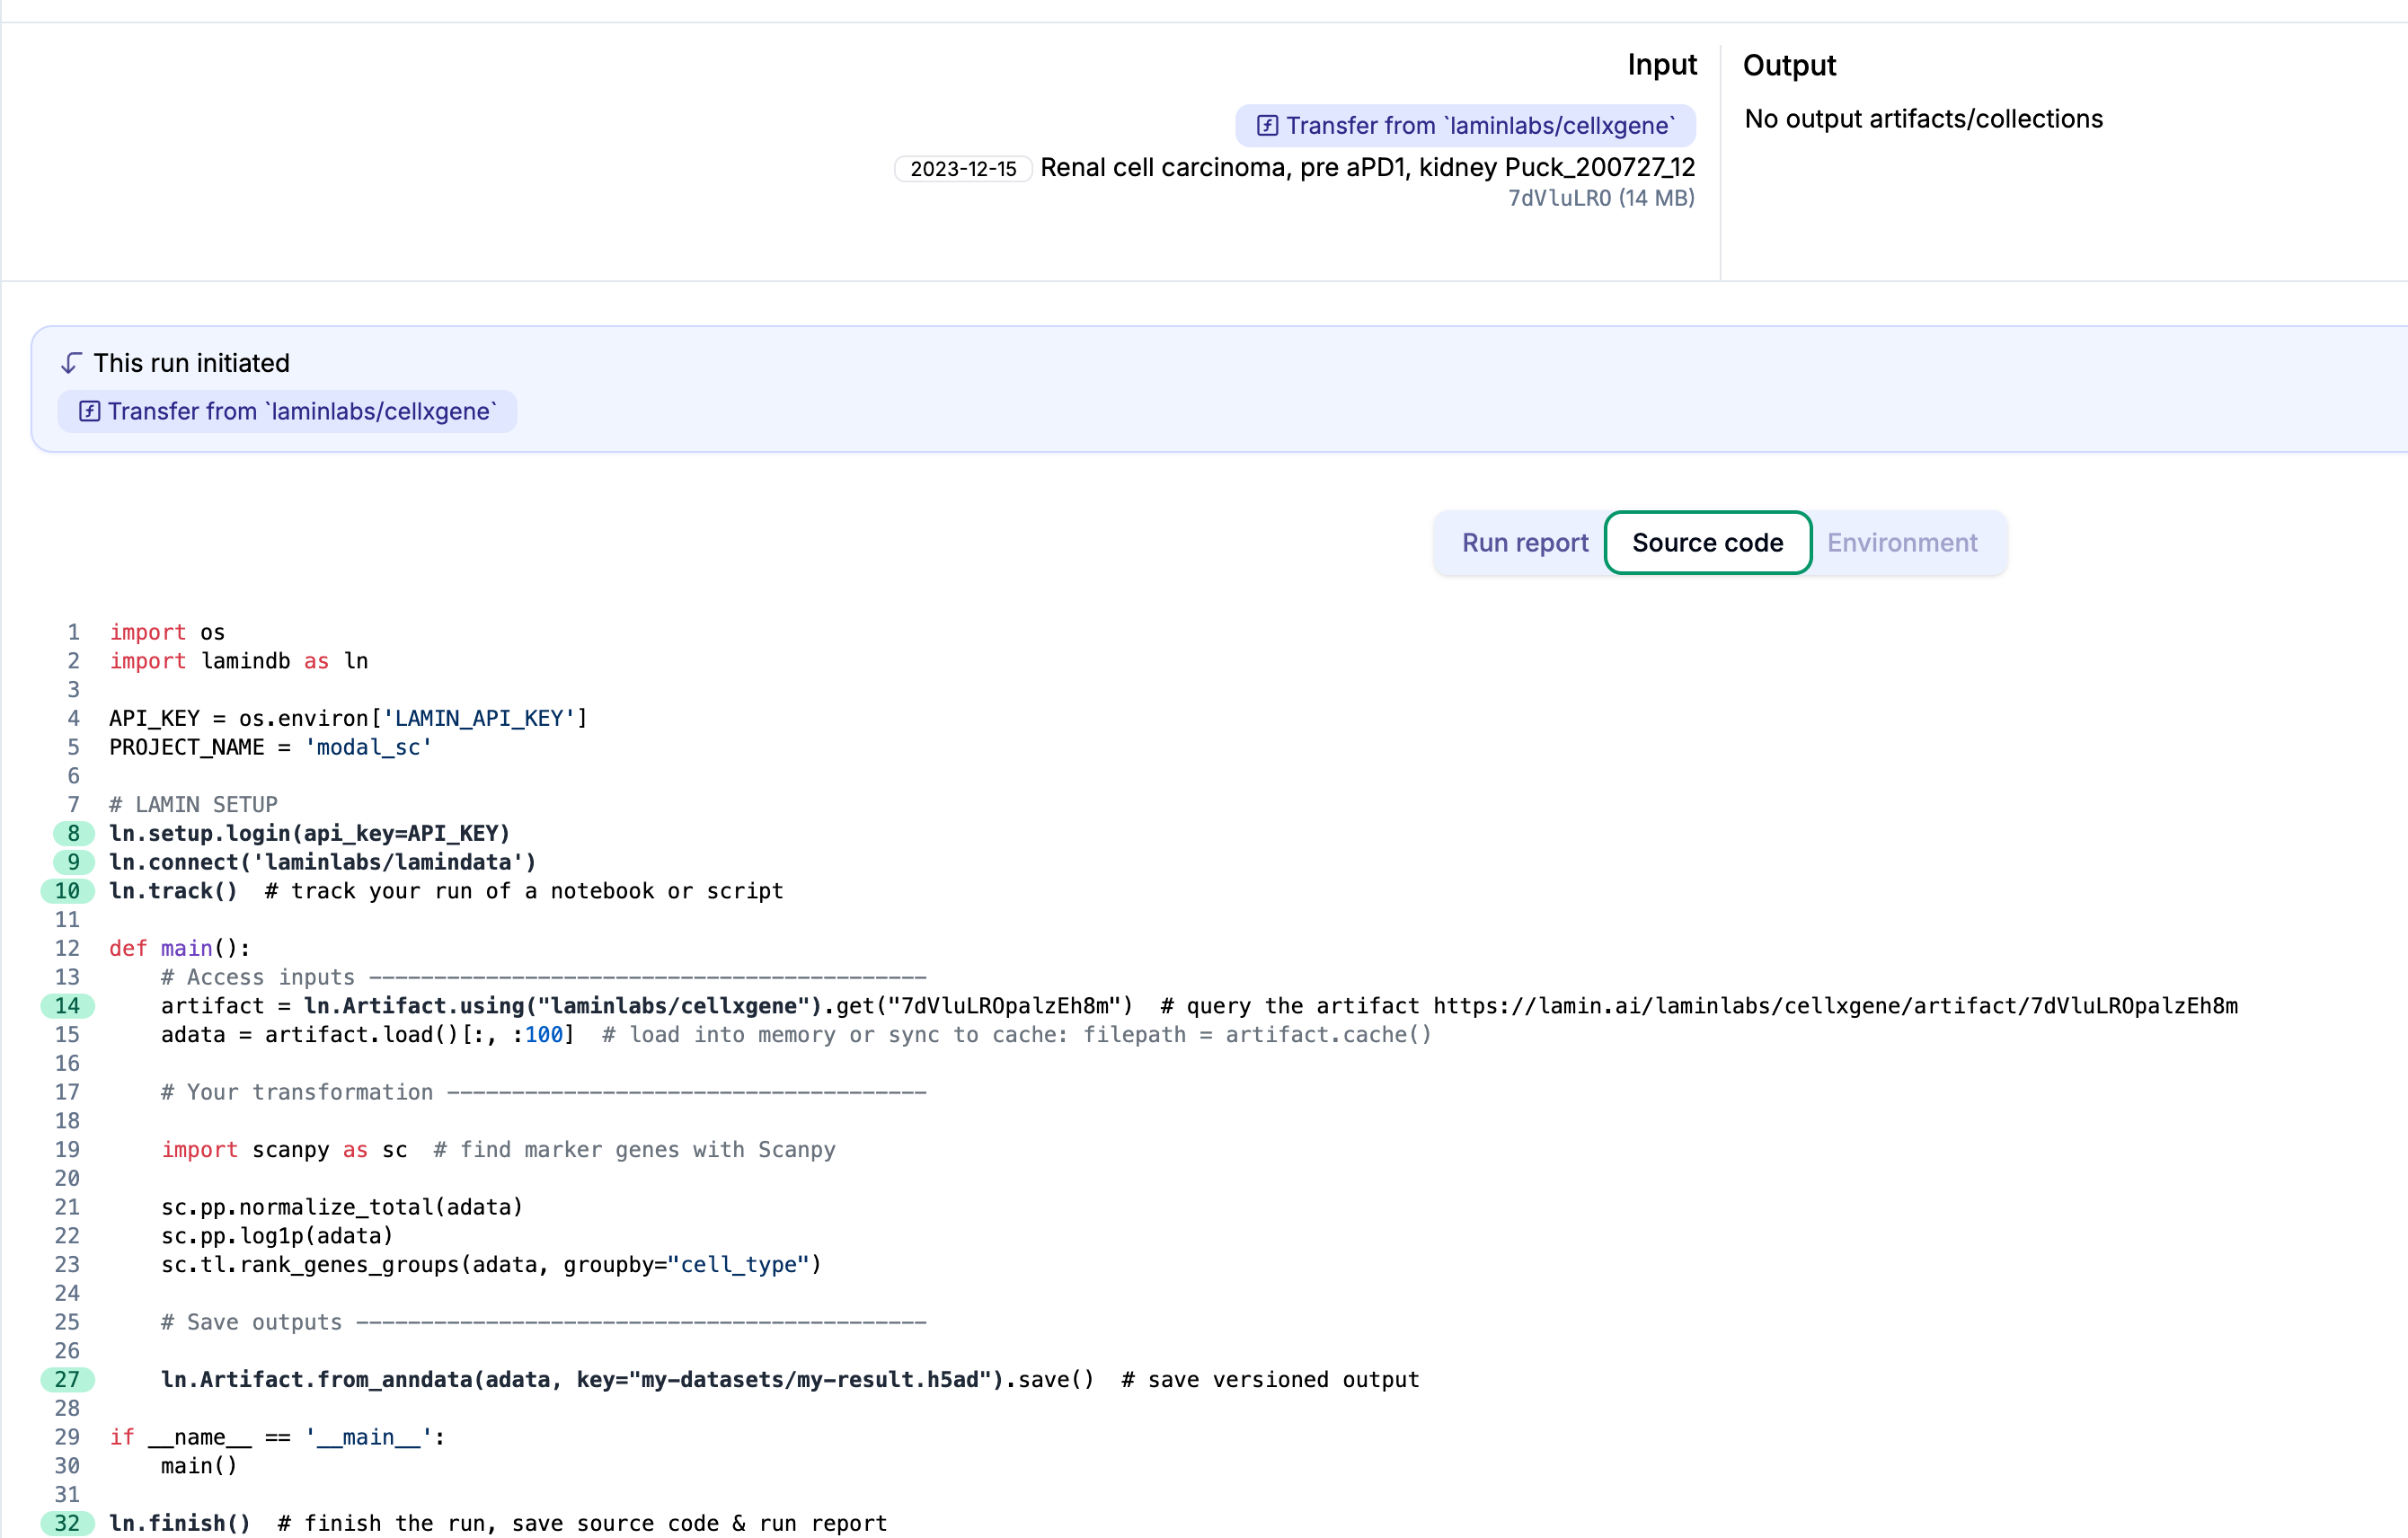

## Specifying dependancies and images

A key component to run compute workloads is access to defining images and environments required to run your code. Below we go over examples where we include custom dependancies and images to the environment to run your code. 

### Save your local script

Below we write a pytorch script and add GPU access to it

In [ ]:
import os
import lamindb as ln

API_KEY = os.environ['lamin_user_api_key']
PROJECT_NAME = os.environ['lamin_project_name']

# LAMIN SETUP
ln.setup.login(api_key=API_KEY)
ln.connect('laminlabs/lamindata')
my_project = ln.Project(name=PROJECT_NAME).save()

ln.track(project=PROJECT_NAME)

def say_hello():
    import torch
    print('Imported pytorch and detecting GPUs')
    print(torch.cuda.is_available())


if __name__ == '__main__':
    say_hello()

ln.finish()

We save the above script locally as `./helloworld_gpu.py` 

To execute your code in the cloud run the following command
``` bash 
lamin run ./helloworld_gpu.py --project lamin_project_gpu --image nvcr.io/nvidia/pytorch:22.12-py3 --packages torch,numpy --gpu T4:1
```

Notice in the above command we specify the `--image` and we additionally add GPU access by passing `--gpu` flag where we specify `T4:1` as the GPU type and number of GPUs to attach to our compute job.

We can also specify additional `pip` dependancies via `--packages` `torch,numpy,seaborn`  

## Training a model on GPU

In [ ]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

import lamindb as ln

# Specify your API KEY - this will automatically be carried from your lamin environment
API_KEY = os.environ['LAMIN_API_KEY']
project_name = 'lamin_train'
# LAMIN SETUP
ln.setup.login(api_key=API_KEY)
ln.connect(f'laminlabs/lamindata')
my_project = ln.Project(name=project_name).save()
ln.track(project=project_name) 

class MNISTModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(28 * 28, 128)
        self.layer_2 = nn.Linear(128, 10)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        return F.log_softmax(x, dim=1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = torch.sum(y == preds).float() / float(y.size(0))
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)
    
    
def main():
    # Check if CUDA is available
    if torch.cuda.is_available():
        print(f"CUDA is available! Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        print("CUDA is not available. Using CPU.")
    
    # Set up data
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
    mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
    
    # Reduce dataset size for quick testing
    mnist_train, _ = random_split(mnist_train, [5000, len(mnist_train) - 5000])
    mnist_test, _ = random_split(mnist_test, [1000, len(mnist_test) - 1000])
    
    train_loader = DataLoader(mnist_train, batch_size=32)
    test_loader = DataLoader(mnist_test, batch_size=32)
    
    # Initialize model and trainer
    model = MNISTModel()
    
    # Set max_epochs to a small number for quick testing
    trainer = pl.Trainer(max_epochs=2, accelerator='gpu')
    
    # Train the model
    trainer.fit(model, train_loader, test_loader)
    
    # Print device info after training
    print(f"Model was trained on: {trainer.accelerator}")
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
    print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1e6:.2f} MB")
    
    
if __name__ == "__main__":
    main()

ln.finish()

save the above locally code in `./lamin_train.py` 

Run the below command to execute the script, install packages in the container & attach a GPU

```
lamin run ./helloworld_train.py --project modal_project_gpu --packages torch,pytorch_lightning,torchvision --image nvcr.io/nvidia/pytorch:22.12-py3 --gpu T4:1
```

In [ ]:
!lamin run ./lamin_train.py --project lamin_train --packages torch,pytorch_lightning,torchvision --image nvcr.io/nvidia/pytorch:22.12-py3 --gpu T4:1